In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
import sys
from os import pardir, mkdir
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

In [3]:
# from utils import rhoDD, frho, rho_tot, f, fdist, nu, nu_mod
from utils import nu_mod, fdist_cum, fdist_pdf

In [28]:
root_data_dir = abspath(join(pardir, "Data"))
name = "Baryon"
data_dir_baryon = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(data_dir_baryon, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


# Framework

Following Buch et. al. ([2019](https://iopscience.iop.org/article/10.1088/1475-7516/2019/04/026))

let $\mathcal{M}$ be a model characterized by parameters $\theta=\{\psi, \xi\}$, such that $\psi=\{\rho_\text{DM}, \Sigma_\text{DM}, h_\text{DM}\}$ are the parameters of interest, and $\xi=\{\rho_i, \sigma_{z;i}, N_\nu, z_\odot\}$

The likelihood is
\begin{aligned}
  p_\nu(d|\mathcal{M}, \theta) = \prod_{i=1}^{N_z} \frac{1}{\sqrt{2\pi \sigma^2_{\text{ln }\nu_i}}}\exp{\left(-\frac{\left[\text{ln}(N_\nu \nu_i^{\text{mod}})-\text{ln } \nu_i^\text{data}\right]^2}{2\sigma^2_{\text{ln }\nu_i}}\right)}
\end{aligned}

Where
* $\nu_i^{\text{mod}}$ is given by `nu_mod` in utils.py
* $\nu_i^{\text{data}}$ is given by `Data/Number-Density/density.hdf5`
* $\sigma^2_{\text{ln }\nu_i}$ is total uncertainty

Total uncertainty is
\begin{aligned}
  \sigma^2_{\text{ln }\nu_i} = \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod}+\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{data}
\end{aligned} 

With the following source of uncertainties
| Type | Source | Treatment |
| ---- | ------ | --------- |
| data | Poisson| sqrt(N)   |
|      | 3% dust| 3% * data |
| mod  | stats  | bootstrap res. |
|      | sys    | asym |

Where the mod uncertainty is
\begin{aligned}
  \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod} = \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, stat}+\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, sys}
\end{aligned} 

$\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, stat}$ is estimated using bootstrap resampling, and

$\left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, sys}$ is estimated from the asymmetry of vertical vel. dist.,
\begin{aligned}
  \left(\sigma^2_{\text{ln }\nu_i}\right)^\text{mod, sys} \approx |\text{ln }\nu^{(w>0)}-\text{ln }\nu^{(w<0)}|
\end{aligned}

## Bootstrap resampling
Check the detail in [Schutz, K., Lin, T., Safdi, B. R., & Wu, C. L. (2018). Constraining a Thin Dark Matter Disk with G a i a. Physical review letters, 121(8), 081101](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.081101) Appendix D

In [5]:
root_data_dir = abspath(join(pardir, "Data"))
data_dir = join(root_data_dir, "Spectral-Class-Velocity")
data_dir

'/home2/s20321005/Thesis-Project/Data/Spectral-Class-Velocity'

In [27]:
a_type = vaex.open(join(data_dir, "A-type.hdf5"))
f_type = vaex.open(join(data_dir, "F-type.hdf5"))
g_type = vaex.open(join(data_dir, "G-type.hdf5"))
g_type

#,w,e_w,spectraltype_esphs
0,-9.590023669072771,0.023956980727508907,F
1,16.547108022089976,0.010300926715071157,G
2,33.16147423530458,0.03313949612412754,G
3,23.232425874782766,0.03457258873567302,G
4,6.200975829380684,0.01760915737454791,G
...,...,...,...
"1,325",16.01534653457238,0.027898021529253764,G
"1,326",-7.1882994564791955,0.012496910009595399,G
"1,327",14.107354617379562,0.018691735437401776,G
"1,328",9.275137350974589,0.013502434199310931,G


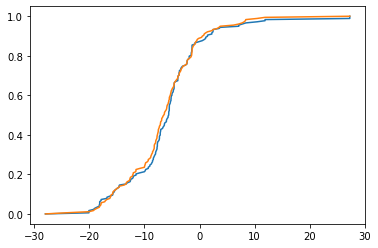

In [63]:
# Resample with replacement
a_type_resampled = a_type.sample(frac=1, replace=True)
# compare
a_num_resampled = a_type_resampled.w.to_numpy()
a_num_resampled = np.sort(a_num_resampled)
a_num = a_type.w.to_numpy()
a_num = np.sort(a_num)
# # plot cumulative
plt.plot(a_num_resampled, np.linspace(0, 1, len(a_num_resampled)))
plt.plot(a_num, np.linspace(0, 1, len(a_num)))

In [8]:
def fdist_cum(w, sigma, w0):
  return norm.cdf(w, loc=w0, scale=sigma)
def fdist_pdf(w, sigma, w0):
  return norm.pdf(w, loc=w0, scale=sigma)

In [ ]:
popt, pcov = curve_fit(fdist_cum, a_num, np.linspace(0, 1, len(a_num)), p0=(1,0))
popt

In [ ]:
ws = np.linspace(-30,30, 100)
plt.figure()
plt.plot(a_num, np.linspace(0, 1, len(a_num)))
plt.plot(ws, fdist_cum(ws, *popt))
plt.show()
plt.figure()
plt.hist(a_num, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt))
plt.show()

In [ ]:
popt_r, pcov = curve_fit(fdist_cum, a_num_resampled, np.linspace(0, 1, len(a_num)), p0=(1,0))
popt_r

In [ ]:
ws = np.linspace(-30,30, 100)
plt.figure()
plt.plot(a_num_resampled, np.linspace(0, 1, len(a_num_resampled)))
plt.plot(ws, fdist_cum(ws, *popt_r))
plt.show()
plt.figure()
plt.hist(a_num_resampled, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt_r))
plt.show()

In [ ]:
plt.figure()
plt.hist(a_num_resampled, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt_r))
plt.hist(a_num, bins=np.linspace(-30,30, 30), density=True)
plt.plot(ws, fdist_pdf(ws, *popt))
plt.show()

In [66]:
# create 1000 bootstrap samples
for t, c in [(a_type, "A"), (f_type, "F"), (g_type, "G")]:
  df = []
  for i in range(1000):
    resampled = t.sample(frac=1, replace=True)
    num_resampled = resampled.w.to_numpy()
    num_resampled = np.sort(num_resampled)
    popt_r, _ = curve_fit(fdist_cum, num_resampled, np.linspace(0, 1, len(num_resampled)), p0=(1,0))
    sigma_v, w0 = popt_r
    cols = dict(sigma_v=[sigma_v], w0=[w0], sample=[i])
    df_new = vaex.from_dict(cols)
    if len(df) == 0:
      df = df_new
    else:
      df = df.concat(df_new)
  df.export(join(data_dir, f"{c}-type-bootstrap.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     1.64s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     1.73s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.72s =  0.0m =  0.0h
 

In [6]:
a_bootstrap_type = vaex.open(join(data_dir, "A-type-bootstrap.hdf5"))
f_bootstrap_type = vaex.open(join(data_dir, "F-type-bootstrap.hdf5"))
g_bootstrap_type = vaex.open(join(data_dir, "G-type-bootstrap.hdf5"))
a_bootstrap_type

#,sigma_v,w0,sample
0,5.788585360683395,-7.236451773135977,0
1,4.6788341506745565,-6.195221483859772,1
2,6.109099400027174,-6.797145826910388,2
3,5.9757782234666905,-6.862668013704516,3
4,5.603674560082213,-7.209796290451144,4
...,...,...,...
995,7.003022582941199,-6.529369648608863,995
996,5.410044015088829,-6.958005597138357,996
997,7.10915076532003,-6.377562354029689,997
998,5.050851152086821,-6.10379377607252,998


The first sample

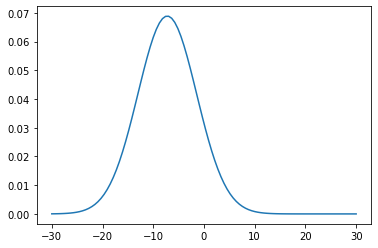

In [7]:
w0 = a_bootstrap_type.w0.to_numpy()[0]
sigma_v = a_bootstrap_type.sigma_v.to_numpy()[0]
ws = np.linspace(-30,30, 100)
plt.figure()
plt.plot(ws, fdist_pdf(ws, sigma_v, w0))

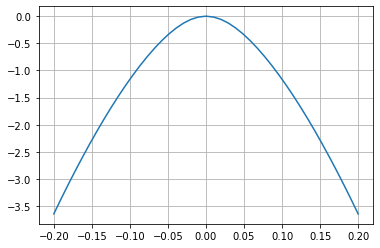

In [15]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)

zz = np.linspace(1, 200, 22)
Z, Nu = nu_mod(zz, theta, sigma_v)
plt.plot(Z, Nu)
plt.grid()

In [20]:
# run 100 bootstrap resampling
sigmas = a_bootstrap_type.sigma_v.to_numpy()
N = len(sigmas)
zz = np.linspace(1, 200, 22)
Zs = np.zeros((N, len(zz)*2))
Nus = np.zeros((N, len(zz)*2))

# initial values
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)

for i, sigma_v in enumerate(sigmas):
  # w0 = a_bootstrap_type.w0.to_numpy()[0]
  Zs[i], Nus[i] = nu_mod(zz, theta, sigma_v)
  if (i % 100 == 0): print(i, end=" ")

0 100 200 300 400 500 600 700 800 900 

<ErrorbarContainer object of 3 artists>

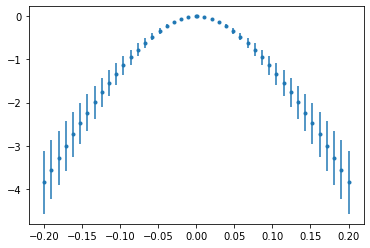

In [21]:
Nu_mean = np.mean(Nus, axis=0)
Nu_std = np.std(Nus, axis=0)
plt.errorbar(Zs[0], Nu_mean, yerr=Nu_std, fmt=".")

In function form

In [31]:
def bootstrap_resampling(func, theta, sigmas, zz):
  """Bootstrap resampling of a function with a distribution"""
  # run N bootstrap resampling
  Zs = np.zeros((len(sigmas), len(zz)*2))
  Nus = np.zeros((len(sigmas), len(zz)*2))

  for i, sigma in enumerate(sigmas):
    Zs[i], Nus[i] = func(zz, theta, sigma)
    if (i % 100 == 0): print(i, end=" ")
  print(f"{i} end")
  Nu_mean = np.mean(Nus, axis=0)
  Nu_std = np.std(Nus, axis=0)
  return Zs[0], Nu_mean, Nu_std

In [29]:
sigmas = a_bootstrap_type.sigma_v.to_numpy()

zz = np.linspace(1, 200, 22)

# initial values
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)

Zs, Nu_mean, Nu_std = bootstrap_resampling(nu_mod, theta, sigmas, zz)

0 100 200 300 400 500 600 700 800 900 

<ErrorbarContainer object of 3 artists>

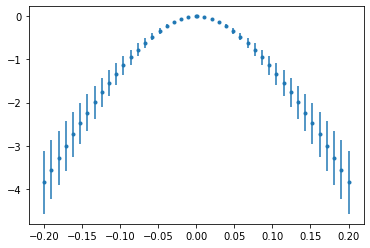

In [32]:
plt.errorbar(Zs, Nu_mean, yerr=Nu_std, fmt=".")

## Asymmetry uncertainties

fit the vertical velocity distribution with 2 gaussian dist

In [135]:
def double_gaussian_cum(x, sigma1, sigma2, w0):
  """Cumulative distribution of a double Gaussian"""
  a = 2*sigma1/(sigma1+sigma2)
  b = 2*sigma2/(sigma1+sigma2)
  return np.heaviside(w0-x, 0.5)*norm.cdf(x, loc=w0, scale=sigma1)*a + np.heaviside(x-w0, 0.5)*((norm.cdf(x, loc=w0, scale=sigma2)-0.5)*b+a/2)
def double_gaussian_pdf(x, sigma1, sigma2, w0):
  a = 2*sigma1/(sigma1+sigma2)
  b = 2*sigma2/(sigma1+sigma2)
  return np.heaviside(w0-x, 0)*norm.pdf(x, loc=w0, scale=sigma1)*a + np.heaviside(x-w0, 1)*norm.pdf(x, loc=w0, scale=sigma2)*b

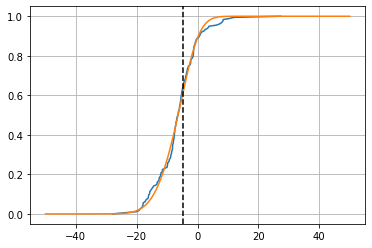

(6.817370096588773, 4.5184907770985125, -4.958645270809794)

In [154]:
a_num = a_type.w.to_numpy()
a_num = np.sort(a_num)
popt, _ = curve_fit(double_gaussian_cum, a_num, np.linspace(0, 1, len(a_num)), p0=(1,1, 0))
sigma_v1, sigma_v2, w0 = popt
ws = np.linspace(-50, 50, 1000)
plt.figure()
plt.plot(a_num, np.linspace(0, 1, len(a_num)))
plt.plot(ws, double_gaussian_cum(ws, *popt))
plt.axvline(w0, color="k", ls="--")
plt.grid()
plt.show()

sigma_v1, sigma_v2, w0

In [155]:
# run 100 bootstrap resampling
zz = np.linspace(1, 200, 22)

# initial values
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)

Zs1, Nus1 = nu_mod(zz, theta, sigma_v1)
Zs2, Nus2 = nu_mod(zz, theta, sigma_v2)

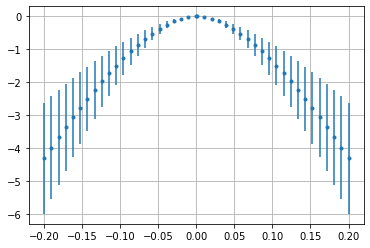

In [156]:
sigma_sys = np.abs(Nus1-Nus2)/2
middle = (Nus1+Nus2)/2
plt.errorbar(Zs1, middle, yerr=sigma_sys, fmt=".")
plt.grid()

In function form

In [157]:
def asymmerty_uncertainties(func, theta, dist, zz):
  popt, _ = curve_fit(double_gaussian_cum, dist, np.linspace(0, 1, len(dist)), p0=(1,1,0))
  sigma_v1, sigma_v2, w0 = popt
  Zs1, Nus1 = func(zz, theta, sigma_v1)
  Zs2, Nus2 = func(zz, theta, sigma_v2)
  sigma_sys = np.abs(Nus1-Nus2)/2
  middle = (Nus1+Nus2)/2
  return Zs1, middle, sigma_sys

In [159]:
# run 100 bootstrap resampling
zz = np.linspace(1, 200, 22)

# initial values
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
rhoDM = 0.016 # Msun/pc^3
sigmaDD = 7 # Msun/pc^2
hDD = 20 # pc

theta = dict(rhos=rhos, sigmaz=sigmaz, rhoDM=rhoDM, sigmaDD=sigmaDD, hDD=hDD, Nv=1, zsun=0)

Zs, middle, sigma_sys = asymmerty_uncertainties(nu_mod, theta, a_num, zz)

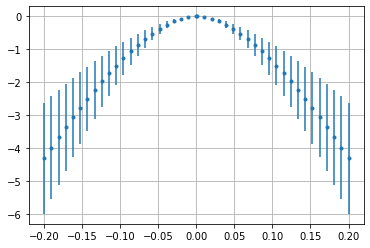

In [160]:
plt.errorbar(Zs, middle, yerr=sigma_sys, fmt=".")
plt.grid()

## Compare

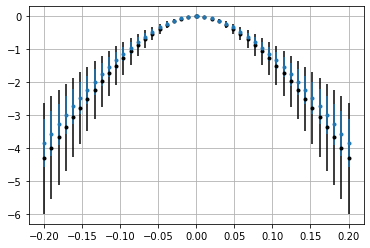

In [162]:
# compare systematic error and statistical error
plt.errorbar(Zs1, middle, yerr=sigma_sys, fmt=".", c="k")
plt.errorbar(Zs, Nu_mean, yerr=Nu_std, fmt=".")
plt.grid()

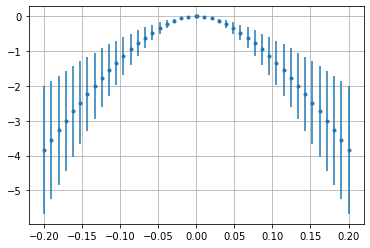

In [163]:
# total mod error
unc_tot = np.sqrt(Nu_std**2+sigma_sys**2)
plt.errorbar(Zs, Nu_mean, yerr=unc_tot, fmt=".")
plt.grid()

Save all relevant functions in utils.py